In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import *
import requests
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import plot_confusion_matrix, classification_report
from collections import Counter 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


### Problem Formulation:
The given dataset is used to predict the Length of Stay of the patients in the Hospitals as 0(if less than 4 days) and 1(if greater than 4 days), using a set of Average costs, Type of Payments and the Codes for the diseases and Procedures. 


In [2]:
train_data_given = pd.read_csv("../input/train-data/train_data.csv")
test_data_given = pd.read_csv("../input/test-data/test_data.csv")

In [3]:
train_data_given.head()
test_data_given.head()

,ID,HealthServiceArea,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode
0,1,New York City,F,Other Race,Newborn,216,3,Medicaid,4900,N,3242,8966,2448,13196,34
1,2,New York City,F,White,Newborn,220,1,Medicaid,3100,N,2611,9227,1751,8951,45
2,3,New York City,M,Multi-racial,Newborn,115,1,Medicaid,3300,N,3155,11381,1052,11314,74
3,4,New York City,M,Other Race,Newborn,228,1,Medicaid,3300,N,2611,9227,3790,6250,45
4,5,New York City,F,Other Race,Newborn,220,2,Medicaid,3800,N,3155,11381,3032,10135,59


Transform the target column to match the task 

In [4]:
train_data_given['LengthOfStay'] = (train_data_given['LengthOfStay'] > 3).astype(int)
print(set((train_data_given['LengthOfStay']).astype(np.int)))

{0, 1}


<AxesSubplot:xlabel='LengthOfStay'>

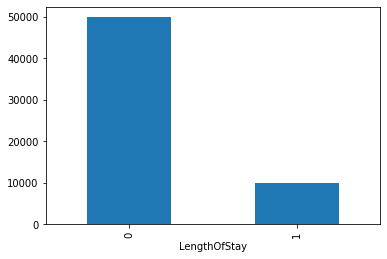

In [5]:
train_data_given.groupby('LengthOfStay').size().plot.bar()

The Length of Stay for maximum number of patients is less than 4. This will reduce the accuracy as we dont have enough data to predict, when the stay is greater than 4.

# **Exploratory Data Analysis (EDA)**

In [6]:
print("----------------- Train data -----------------\n")
train_data_given.info()
print("----------------- Test data ----------------- \n")
test_data_given.info()

----------------- Train data -----------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59966 entries, 0 to 59965
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ID                            59966 non-null  int64 
 1   HealthServiceArea             59966 non-null  object
 2   Gender                        59966 non-null  object
 3   Race                          59966 non-null  object
 4   TypeOfAdmission               59966 non-null  object
 5   CCSProcedureCode              59966 non-null  int64 
 6   APRSeverityOfIllnessCode      59966 non-null  int64 
 7   PaymentTypology               59966 non-null  object
 8   BirthWeight                   59966 non-null  int64 
 9   EmergencyDepartmentIndicator  59966 non-null  object
 10  AverageCostInCounty           59966 non-null  int64 
 11  AverageChargesInCounty        59966 non-null  int64 
 12  AverageCostInFacility     

The test data does not have the target column,rest of the column names are similar in the train and test data.

In [7]:
train_data_given.describe()

,ID,CCSProcedureCode,APRSeverityOfIllnessCode,BirthWeight,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
count,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000
mean,29983.500000,155.404229,1.254594,3336.298903,2372.806690,7979.126922,2396.414318,7958.472668,59.811143,0.167945
std,17310.837458,89.541978,0.546207,446.244475,639.755096,3220.291347,1248.501189,3859.294711,21.470170,0.373821
min,1.000000,-1.000000,1.000000,2500.000000,712.000000,1243.000000,457.000000,1120.000000,28.000000,0.000000
25%,14992.250000,115.000000,1.000000,3000.000000,2041.000000,4620.000000,1551.000000,4438.000000,45.000000,0.000000
50%,29983.500000,220.000000,1.000000,3300.000000,2533.000000,9227.000000,1967.000000,7945.000000,55.000000,0.000000
75%,44974.750000,228.000000,1.000000,3600.000000,2785.000000,10644.000000,2895.000000,11619.000000,74.000000,0.000000
max,59966.000000,231.000000,4.000000,7500.000000,3242.000000,11381.000000,8114.000000,18466.000000,115.000000,1.000000


In [8]:
test_data_given.describe()

,ID,CCSProcedureCode,APRSeverityOfIllnessCode,BirthWeight,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode
count,69177.000000,69177.000000,69177.000000,69177.000000,69177.000000,69177.000000,69177.000000,69177.000000,69177.000000
mean,34589.000000,153.638796,1.244792,3330.408951,2552.165763,7931.159793,2543.578169,7922.475563,60.594750
std,19969.824123,93.178044,0.521187,436.355795,725.397646,2825.156928,1410.789231,3865.295769,21.637225
min,1.000000,-1.000000,1.000000,2500.000000,631.000000,1491.000000,631.000000,1491.000000,28.000000
25%,17295.000000,115.000000,1.000000,3000.000000,1944.000000,6546.000000,1494.000000,5157.000000,45.000000
50%,34589.000000,220.000000,1.000000,3300.000000,2611.000000,8966.000000,2138.000000,6915.000000,57.000000
75%,51883.000000,228.000000,1.000000,3600.000000,3155.000000,9917.000000,3338.000000,11011.000000,74.000000
max,69177.000000,231.000000,4.000000,9000.000000,3623.000000,11381.000000,6953.000000,22564.000000,115.000000


In [9]:
train_data_given.describe(include=['O'])

,HealthServiceArea,Gender,Race,TypeOfAdmission,PaymentTypology,EmergencyDepartmentIndicator
count,59966,59966,59966,59966,59966,59966
unique,6,3,4,4,9,2
top,New York City,M,White,Newborn,Medicaid,N
freq,27235,30978,32943,58741,28723,59453


In [10]:
test_data_given.describe(include=['O'])

,HealthServiceArea,Gender,Race,TypeOfAdmission,PaymentTypology,EmergencyDepartmentIndicator
count,69177,69177,69177,69177,69177,69177
unique,3,3,4,5,10,2
top,New York City,M,White,Newborn,Medicaid,N
freq,38642,35471,30432,68125,37037,68829


The describe function shows that there are no missing values in both the dataframes.

The type of data for the columns can be infered as follows:
* **Ordinal categorical variables:** TypeOfAdmission, PaymentTypology, EmergencyDepartmentIndicator, CCSProcedureCode, APRSeverityOfIllnessCode
* **Nominal categorical variables:** Gender, Race
* **Continuos:** BirthWeight, AverageCostInCounty, AverageChargesInCounty, AverageCostInFacility, AverageChargesInFacility, AverageIncomeInZipCode

In [11]:
pd.isna(train_data_given).sum()

ID                              0
HealthServiceArea               0
Gender                          0
Race                            0
TypeOfAdmission                 0
CCSProcedureCode                0
APRSeverityOfIllnessCode        0
PaymentTypology                 0
BirthWeight                     0
EmergencyDepartmentIndicator    0
AverageCostInCounty             0
AverageChargesInCounty          0
AverageCostInFacility           0
AverageChargesInFacility        0
AverageIncomeInZipCode          0
LengthOfStay                    0
dtype: int64

The count is 59966 in for the columns,So No missing values. 

In [12]:
pd.isna(test_data_given).sum()

ID                              0
HealthServiceArea               0
Gender                          0
Race                            0
TypeOfAdmission                 0
CCSProcedureCode                0
APRSeverityOfIllnessCode        0
PaymentTypology                 0
BirthWeight                     0
EmergencyDepartmentIndicator    0
AverageCostInCounty             0
AverageChargesInCounty          0
AverageCostInFacility           0
AverageChargesInFacility        0
AverageIncomeInZipCode          0
dtype: int64

The count is 69177 in for the columns,So No missing values. 

In [13]:
print("The shape of train data :{},and test data :{}".format(train_data_given.shape, test_data_given.shape))

The shape of train data :(59966, 16),and test data :(69177, 15)


In [14]:
train_data_given.head()

,ID,HealthServiceArea,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
0,1,New York City,F,Other Race,Newborn,228,1,Medicaid,3700,N,2611,9227,1751,8951,45,0
1,2,New York City,M,Black/African American,Newborn,228,1,Medicaid,2900,N,3242,8966,3338,6409,34,0
2,3,New York City,M,Other Race,Newborn,220,1,Private Health Insurance,3200,N,3155,11381,4980,9323,45,0
3,4,New York City,F,Other Race,Newborn,0,1,Private Health Insurance,3300,N,3155,11381,5826,15680,59,0
4,5,New York City,F,Other Race,Newborn,228,1,Medicaid,2600,N,2611,9227,6000,14344,59,0


In [15]:
test_data_given.head()  

,ID,HealthServiceArea,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode
0,1,New York City,F,Other Race,Newborn,216,3,Medicaid,4900,N,3242,8966,2448,13196,34
1,2,New York City,F,White,Newborn,220,1,Medicaid,3100,N,2611,9227,1751,8951,45
2,3,New York City,M,Multi-racial,Newborn,115,1,Medicaid,3300,N,3155,11381,1052,11314,74
3,4,New York City,M,Other Race,Newborn,228,1,Medicaid,3300,N,2611,9227,3790,6250,45
4,5,New York City,F,Other Race,Newborn,220,2,Medicaid,3800,N,3155,11381,3032,10135,59


## Data Distribution

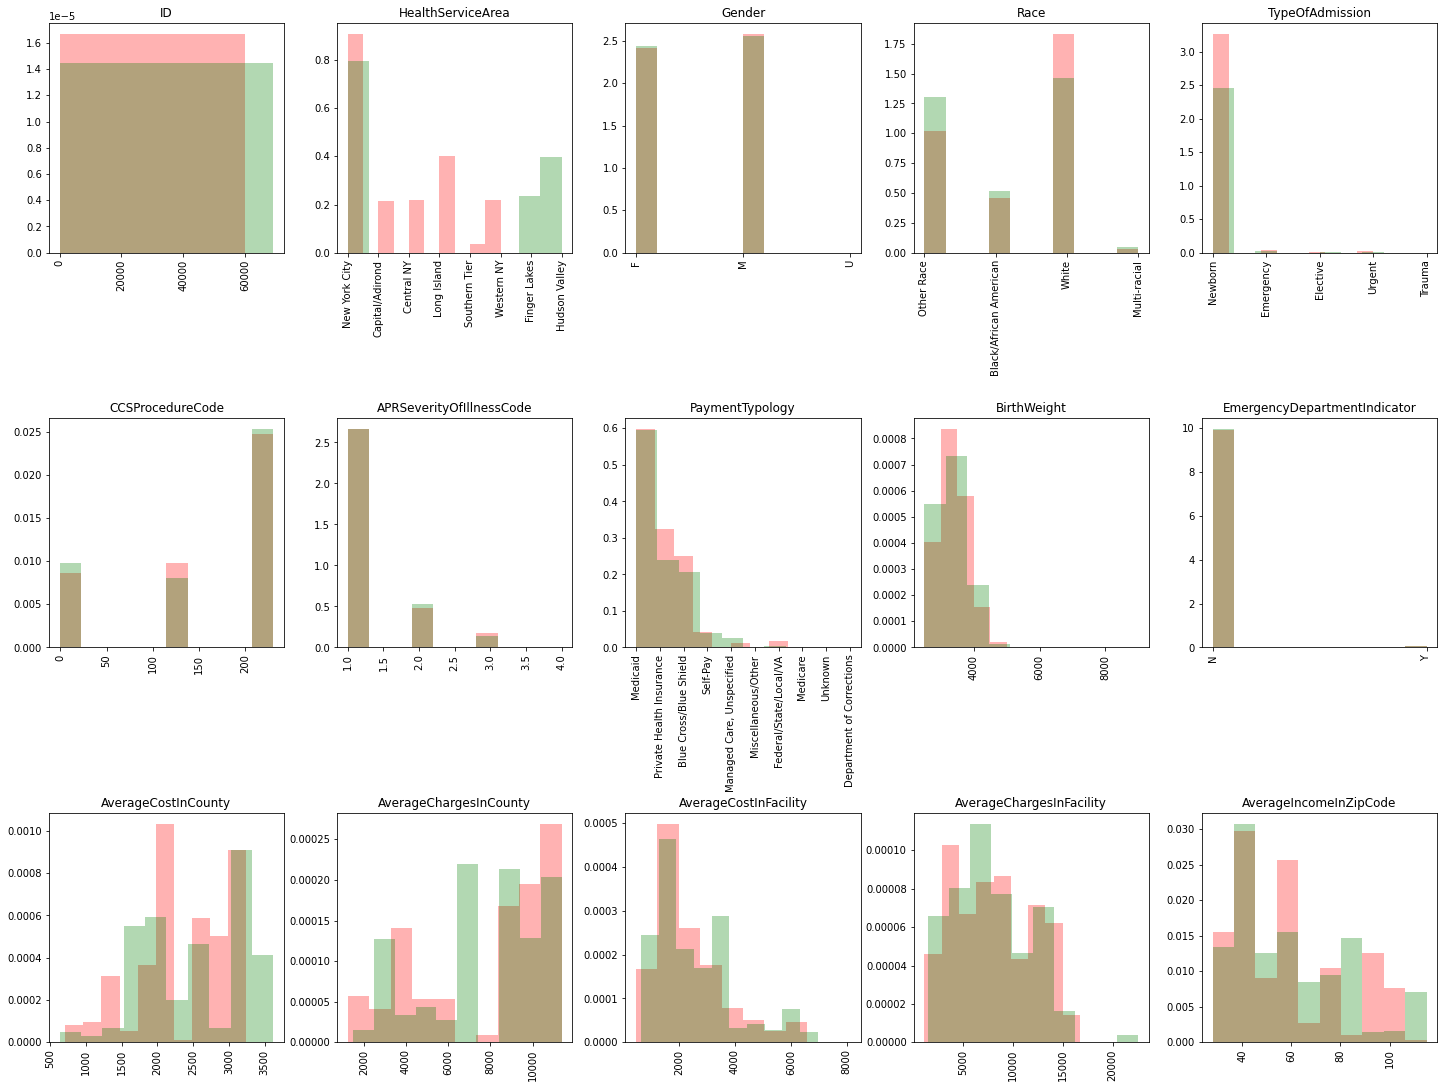

In [16]:
fig = plt.figure(figsize=(20,20))
for i, col in enumerate(train_data_given.columns):
    if col!= 'LengthOfStay':
        plt.subplot(4,5,i+1)
        #_, bins, _ = plt.hist(train_data_given[col], alpha=0.3, color='b', density=True)
        plt.hist(train_data_given[col], alpha=0.3, color='r', density=True)
        plt.hist(test_data_given[col], alpha=0.3, color='g', density=True)
        plt.title(col)
        plt.xticks(rotation='vertical')
        
fig.tight_layout(pad=0.5)

The train data and the test data are plotted as a histogram.
We can infer that the two columns have an extra type:
* PaymentTopology - Department of Corrections
* TypeOfAdmission - Trauma 

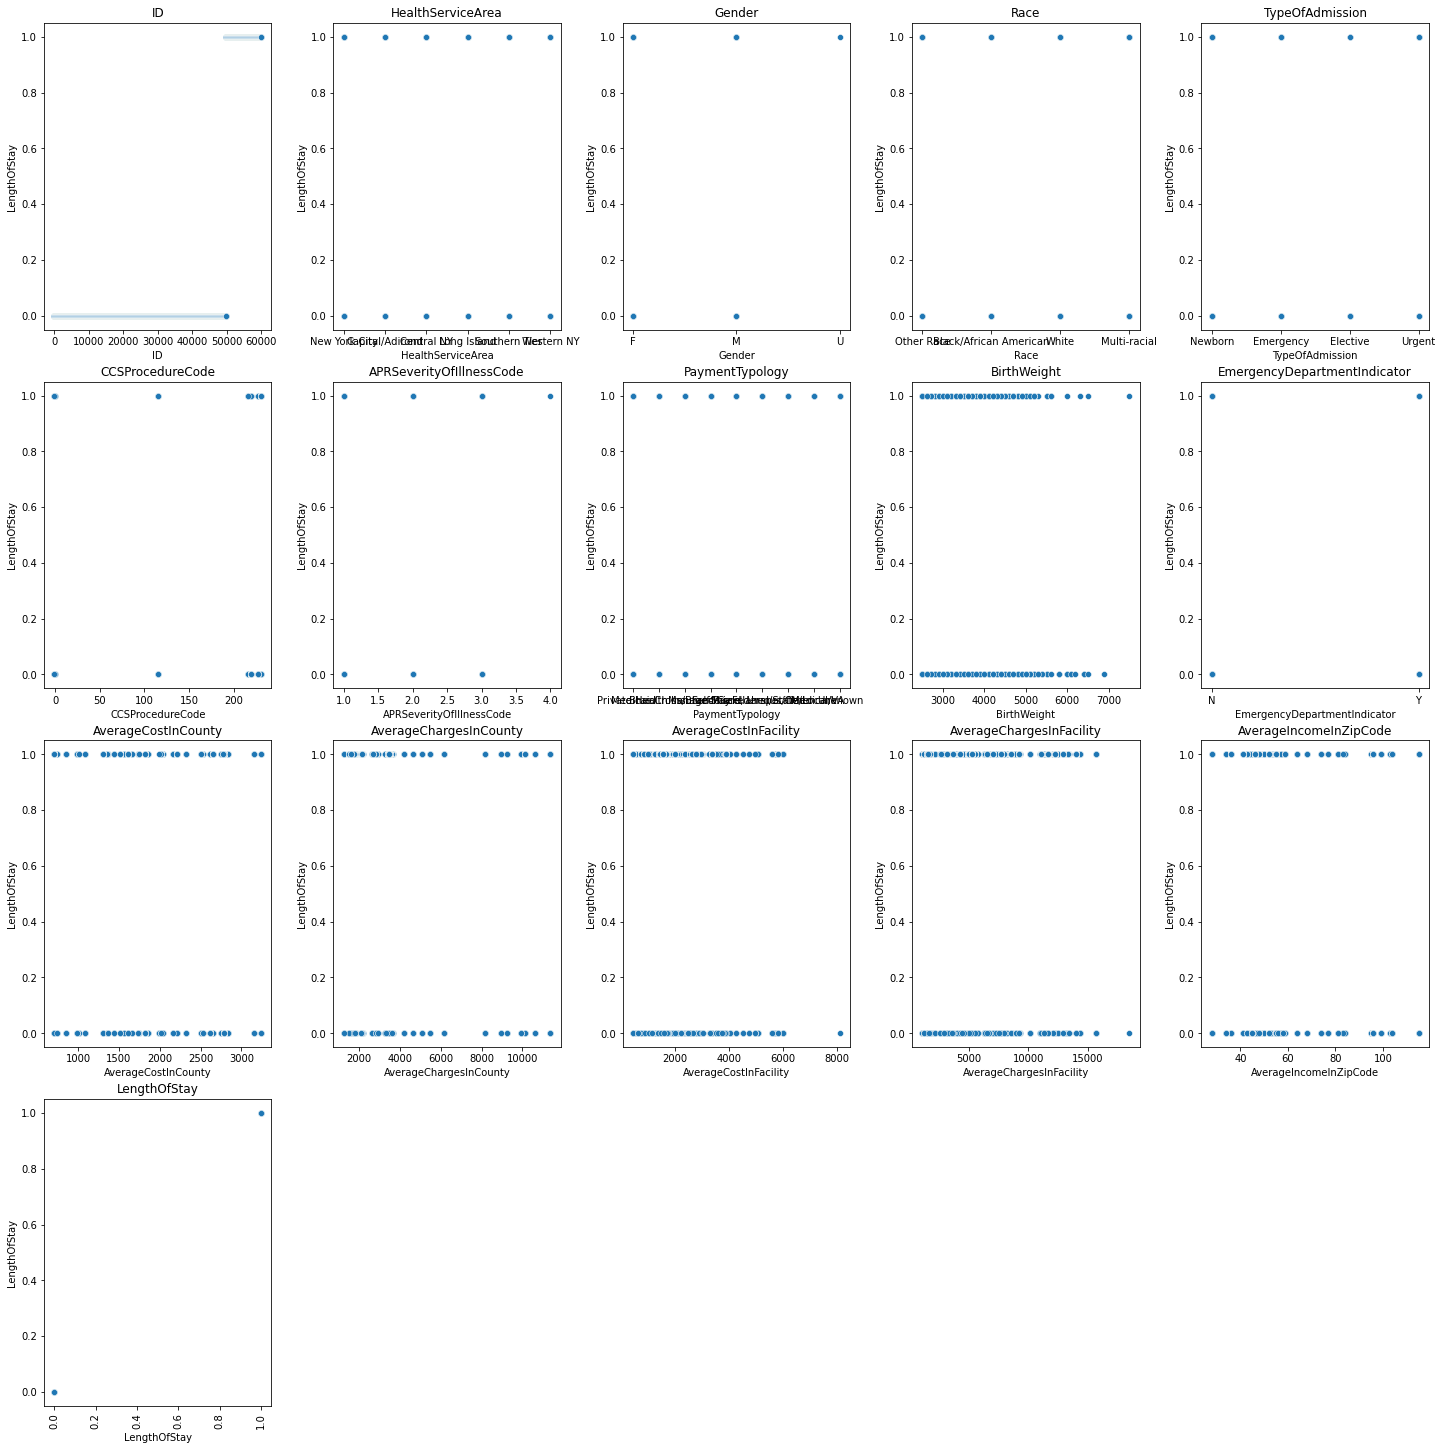

In [17]:
import seaborn as sns
fig = plt.figure(figsize=(20,20))
for i, col in enumerate(train_data_given.columns):
    plt.subplot(4,5,i+1)
    sns.scatterplot(data=train_data_given, x=col, y='LengthOfStay')
    plt.title(col)

fig.tight_layout(pad=0.5)
plt.xticks(rotation='vertical')
plt.show()

This graph helps to classify between the continuous and Categorical columns. An also that the value for the first 500000 IDs is 0 and rest is 1. Hence it is important to split the data at random. 

### **Label Encoding**
We know that the columns TypeOfAdmission, PaymentTypology have an extra type. OneHotEncoding is not a good option as the number of columns will be unequal in the test and train data. Hence, LabelEncoder is applied to these two columns

In [18]:
from sklearn.preprocessing import LabelEncoder
labelEncoding = ['TypeOfAdmission','PaymentTypology']

train_data_given[labelEncoding] = train_data_given[labelEncoding].apply(LabelEncoder().fit_transform)
test_data_given[labelEncoding] = test_data_given[labelEncoding].apply(LabelEncoder().fit_transform)

In [19]:
train_data_given.head()

,ID,HealthServiceArea,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
0,1,New York City,F,Other Race,2,228,1,3,3700,N,2611,9227,1751,8951,45,0
1,2,New York City,M,Black/African American,2,228,1,3,2900,N,3242,8966,3338,6409,34,0
2,3,New York City,M,Other Race,2,220,1,6,3200,N,3155,11381,4980,9323,45,0
3,4,New York City,F,Other Race,2,0,1,6,3300,N,3155,11381,5826,15680,59,0
4,5,New York City,F,Other Race,2,228,1,3,2600,N,2611,9227,6000,14344,59,0


In [20]:
test_data_given.head()

,ID,HealthServiceArea,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode
0,1,New York City,F,Other Race,2,216,3,4,4900,N,3242,8966,2448,13196,34
1,2,New York City,F,White,2,220,1,4,3100,N,2611,9227,1751,8951,45
2,3,New York City,M,Multi-racial,2,115,1,4,3300,N,3155,11381,1052,11314,74
3,4,New York City,M,Other Race,2,228,1,4,3300,N,2611,9227,3790,6250,45
4,5,New York City,F,Other Race,2,220,2,4,3800,N,3155,11381,3032,10135,59


### One Hot Encoding: For Train Data
One hot encoding is applied for the following categorical variables.
* Gender, Race, EmergencyDepartmentIndicator, CCSProcedureCode, APRSeverityOfIllnessCode


In [21]:
from sklearn.preprocessing import OneHotEncoder
ForOneHotEncoding = ['Gender','Race','EmergencyDepartmentIndicator', 'CCSProcedureCode', 'APRSeverityOfIllnessCode']

OneHot_train_data_columns = OneHotEncoder(handle_unknown='ignore')
for columns in ForOneHotEncoding:
    OneHot_train_data_columns.fit(train_data_given[columns].values.reshape(-1,1))
    train_data_OneHot = OneHot_train_data_columns.transform(train_data_given[columns].values.reshape(-1,1)).toarray()
    for i in range(len(OneHot_train_data_columns.categories_[0])):
        train_data_given[columns + '_' + str(OneHot_train_data_columns.categories_[0][i])] = train_data_OneHot[:,i]
    train_data_given = train_data_given.drop([columns],axis=1)
    
train_data_given.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59966 entries, 0 to 59965
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              59966 non-null  int64  
 1   HealthServiceArea               59966 non-null  object 
 2   TypeOfAdmission                 59966 non-null  int64  
 3   PaymentTypology                 59966 non-null  int64  
 4   BirthWeight                     59966 non-null  int64  
 5   AverageCostInCounty             59966 non-null  int64  
 6   AverageChargesInCounty          59966 non-null  int64  
 7   AverageCostInFacility           59966 non-null  int64  
 8   AverageChargesInFacility        59966 non-null  int64  
 9   AverageIncomeInZipCode          59966 non-null  int64  
 10  LengthOfStay                    59966 non-null  int64  
 11  Gender_F                        59966 non-null  float64
 12  Gender_M                        

### One Hot Encoding: For Test Data

In [22]:
OneHot_test_data_columns = OneHotEncoder(handle_unknown='ignore')
for columns in ForOneHotEncoding:
    OneHot_test_data_columns.fit(test_data_given[columns].values.reshape(-1,1))
    test_data_OneHot = OneHot_test_data_columns.transform(test_data_given[columns].values.reshape(-1,1)).toarray()
    for i in range(len(OneHot_test_data_columns.categories_[0])):
        test_data_given[columns + '_' + str(OneHot_test_data_columns.categories_[0][i])] = test_data_OneHot[:,i]
    test_data_given = test_data_given.drop([columns],axis=1)
    
test_data_given.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69177 entries, 0 to 69176
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              69177 non-null  int64  
 1   HealthServiceArea               69177 non-null  object 
 2   TypeOfAdmission                 69177 non-null  int64  
 3   PaymentTypology                 69177 non-null  int64  
 4   BirthWeight                     69177 non-null  int64  
 5   AverageCostInCounty             69177 non-null  int64  
 6   AverageChargesInCounty          69177 non-null  int64  
 7   AverageCostInFacility           69177 non-null  int64  
 8   AverageChargesInFacility        69177 non-null  int64  
 9   AverageIncomeInZipCode          69177 non-null  int64  
 10  Gender_F                        69177 non-null  float64
 11  Gender_M                        69177 non-null  float64
 12  Gender_U                        

# Data Distribution

Standard Scalar to standardize the values in the following columns as 
* BirthWeight, AverageCostInCounty, AverageChargesInCounty, AverageCostInFacility, AverageChargesInFacility
As they have numerical values which are widely distributed. 

In [23]:
from sklearn.preprocessing import StandardScaler

Standard_scale = ['BirthWeight','AverageCostInCounty','AverageChargesInCounty','AverageCostInFacility','AverageChargesInFacility']

#For Train data
train_fit_Scaler = StandardScaler().fit(train_data_given[Standard_scale])
train_Standard_transform = train_fit_Scaler.transform(train_data_given[Standard_scale])

#For Test data
test_fit_Scaler = StandardScaler().fit(test_data_given[Standard_scale])
test_Standard_transform = test_fit_Scaler.transform(test_data_given[Standard_scale])

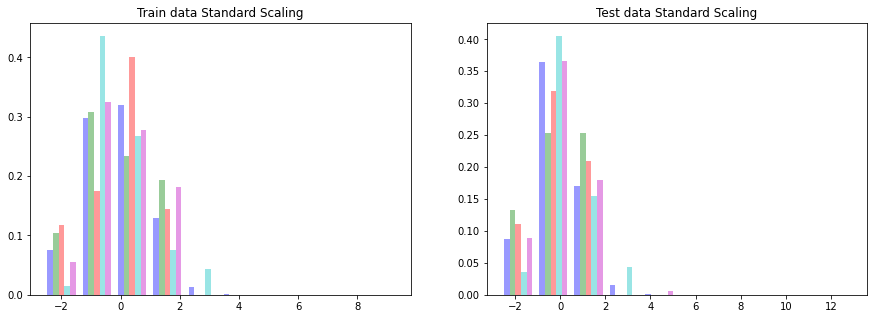

In [24]:
colors = ['b', 'g', 'r' ,'c', 'm']

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(train_Standard_transform, alpha=0.4, color=colors, density=True)
plt.title("Train data Standard Scaling")

plt.subplot(1,2,2)
plt.hist(test_Standard_transform, alpha=0.4, color=colors, density=True)
plt.title("Test data Standard Scaling") 
plt.show()

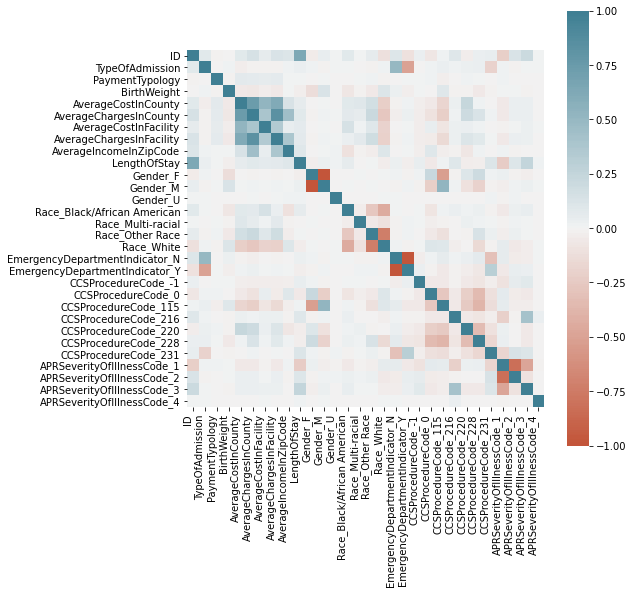

In [25]:
import seaborn as sns

f, ax = plt.subplots(figsize=(8,8))
corr = train_data_given.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right');

There exits a correlation between the columns which involves cost like AverageCostInCounty, AverageChargesInCounty, AverageCostInFacility, AverageChargesInFacility.

## Hold-out Validation

In [26]:
from sklearn.model_selection import train_test_split

with pd.option_context('mode.chained_assignment', None):
    train_data_val, test_data = train_test_split(train_data_given, test_size=0.2,shuffle=True,random_state=0)
    
with pd.option_context('mode.chained_assignment', None):
    train_data, val_data = train_test_split(train_data_val, test_size=0.2,shuffle=True,random_state=0)
    
print("The shape of train data :{}, validation data :{}, test data :{}".format(train_data.shape, val_data.shape, test_data.shape))


The shape of train data :(38377, 31), validation data :(9595, 31), test data :(11994, 31)


In [27]:
X_train = train_data.drop(['ID','LengthOfStay','HealthServiceArea'], axis=1).to_numpy()
y_train = train_data[['LengthOfStay']].to_numpy()

X_test = test_data.drop(['ID','LengthOfStay','HealthServiceArea'], axis=1).to_numpy()
y_test = test_data[['LengthOfStay']].to_numpy()

X_val = val_data.drop(['ID','LengthOfStay','HealthServiceArea'], axis=1).to_numpy()
y_val = val_data[['LengthOfStay']].to_numpy()

Function to get the performance(f1_score)

In [28]:
from sklearn.metrics import f1_score

def get_f1_scores(clf, train_X, train_y, val_X, val_y):
    train_pred = clf.predict(train_X)
    val_pred = clf.predict(val_X)
    train_f1 = f1_score(train_y, train_pred, average='micro')
    val_f1 = f1_score(val_y, val_pred, average='micro')
    return train_f1, val_f1

## Data Modelling 

### Baseline model

LogisticRegression is the best baseline model, as we have to predict the values 0 and 1 for the Length Of Stay. Only 2 possible outcomes.

In [44]:
logisticRegression = LogisticRegression(random_state=0, penalty='none', max_iter=1000 ).fit(X_train, y_train.ravel())

logisticRegression_test_pred = logisticRegression.predict(X_test)

train_f1, val_f1 = get_f1_scores(logisticRegression, X_train, y_train, X_val, y_val)
print("Train F1-Score score: {:.3f}".format(train_f1))
print("Validation F1-Score score: {:.3f}".format(val_f1))

Train F1-Score score: 0.839
Validation F1-Score score: 0.842


The difference between the F1-score of train and validation data is negligible. Hence there is no need for Regularization.

Hyperparameter tuning: 
The penalty is set to 'none' as setting it to 'l2' is reducing the 


### Decision Tree Model 

In [30]:
dtree = DecisionTreeClassifier(random_state=0, max_depth=3)
decisionTree = dtree.fit(X_train,y_train)

test_pred = decisionTree.predict(X_test)
# train_pred = decisionTree.predict(X_train)

train_f1, val_f1 = get_f1_scores(decisionTree, X_train, y_train, X_val, y_val)
print("Train F1-Score score: {:.3f}".format(train_f1))
print("Validation F1-Score score: {:.3f}".format(val_f1))

Train F1-Score score: 0.840
Validation F1-Score score: 0.845


### Random Forest model

In [31]:
randomForest = RandomForestClassifier(max_depth=5, n_estimators=100)
randomForest.fit(X_train,y_train.ravel())

y_pred=randomForest.predict(X_test)

# train_pred = randomForest.predict(X_train)

train_f1, val_f1 = get_f1_scores(randomForest, X_train, y_train, X_val, y_val)
print("Train F1-Score score: {:.3f}".format(train_f1))
print("Validation F1-Score score: {:.3f}".format(val_f1))

Train F1-Score score: 0.842
Validation F1-Score score: 0.844


## Testing the model

### Logistic Regression - Baseline Model 


--------------- Classification Report -------------

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      9943
           1       0.55      0.10      0.17      2051

    accuracy                           0.83     11994
   macro avg       0.70      0.54      0.54     11994
weighted avg       0.79      0.83      0.78     11994


--------------- Confusion Matrix -------------



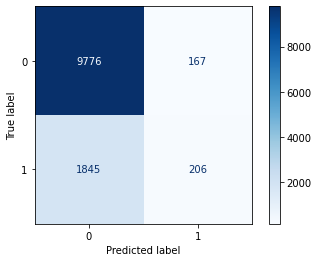

In [45]:
print("\n--------------- Classification Report -------------\n")
print(classification_report(y_test, logisticRegression_test_pred,))

print("\n--------------- Confusion Matrix -------------\n")
display_logisticRegression = plot_confusion_matrix(logisticRegression, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

### Decision Tree Model


--------------- Classification Report -------------

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      9943
           1       0.57      0.17      0.27      2051

    accuracy                           0.84     11994
   macro avg       0.71      0.57      0.59     11994
weighted avg       0.80      0.84      0.80     11994


--------------- Confusion Matrix -------------



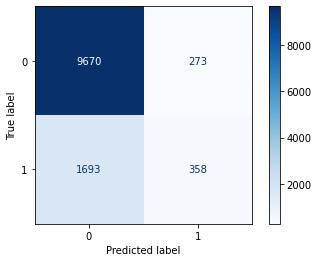

In [33]:
print("\n--------------- Classification Report -------------\n")
# print(classification_report(y_train, train_pred,))
print(classification_report(y_test, test_pred,))

print("\n--------------- Confusion Matrix -------------\n")
display = plot_confusion_matrix(decisionTree, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

### Random Forest Model


--------------- Classification Report -------------

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      9943
           1       0.69      0.08      0.14      2051

    accuracy                           0.84     11994
   macro avg       0.76      0.54      0.52     11994
weighted avg       0.81      0.84      0.78     11994


--------------- Confusion Matrix -------------



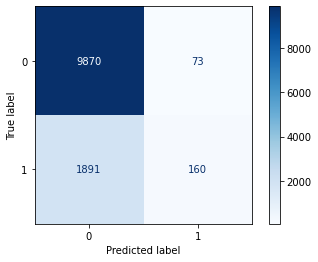

In [34]:
print("\n--------------- Classification Report -------------\n")
# print(classification_report(y_train, train_pred,))
print(classification_report(y_test, y_pred,))

print("\n--------------- Confusion Matrix -------------\n")
disp = plot_confusion_matrix(randomForest, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [35]:
# print(X.shape[0], y.shape[0])

In [36]:
## TODO

# fig = plt.figure(figsize=(20,20))
# for i, col in enumerate(data.columns):
#     plt.subplot(4,5,i+1)
#     _, bins, _ = plt.hist(X[col], alpha=0.3, color='r', density=True)
#     plt.hist(y[col], bins=bins, alpha=0.3, color='b', density=True)
#     plt.title(col)
#     plt.xticks(rotation='vertical')
# fig.tight_layout(pad=0.5)

# Data Pre-processing (or Transforming)

In [37]:
from sklearn.model_selection import train_test_split

with pd.option_context('mode.chained_assignment', None):
    train_data, test_data = train_test_split(train_data_given, test_size=0.2, shuffle=True,random_state=0)
    
print(train_data.shape[0], test_data.shape[0])

train_X = train_data.drop(['ID','LengthOfStay','HealthServiceArea'], axis=1).to_numpy()
train_y = train_data[['LengthOfStay']].to_numpy()

test_X = test_data.drop(['ID','LengthOfStay','HealthServiceArea'], axis=1).to_numpy()
test_y = test_data[['LengthOfStay']].to_numpy()

47972 11994


In [38]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, make_scorer

f1_scorer = make_scorer(f1_score, average='weighted')
lambda_paras = np.logspace(-20, 2, num=5)

cv_results = dict()

for lambda_para in lambda_paras:
    clf = LogisticRegression(penalty='l2', C = 1.0/lambda_para, 
                             solver='liblinear', max_iter=500, 
                             class_weight='balanced')
    
    scores = cross_validate(clf, train_X, train_y.ravel(), 
                            scoring=f1_scorer, return_estimator=True,
                            return_train_score=True, cv=5)
    
    cv_results[lambda_para] = scores

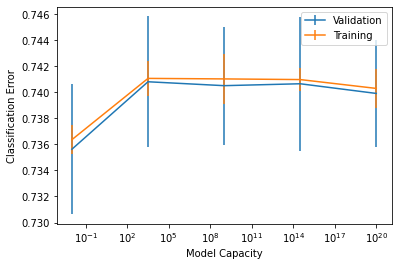

In [39]:
fig, ax = plt.subplots()

val_means = [np.mean(cv_results[lambda_para]['test_score']) 
             for lambda_para in lambda_paras]

val_std = [np.std(cv_results[lambda_para]['test_score']) 
           for lambda_para in lambda_paras]

train_means = [np.mean(cv_results[lambda_para]['train_score']) 
               for lambda_para in lambda_paras]

train_std = [np.std(cv_results[lambda_para]['train_score']) 
             for lambda_para in lambda_paras]

ax.errorbar([1.0/lambda_para for lambda_para in lambda_paras], 
            val_means,
            yerr=val_std)

ax.errorbar([1.0/lambda_para for lambda_para in lambda_paras], 
            train_means,
            yerr=train_std)

plt.xscale("log")
plt.ylabel('Classification Error')
plt.xlabel('Model Capacity')
plt.legend(['Validation','Training',])
plt.show()